In [10]:
import numpy as np
import torch
from torch import nn
import hypnettorch
from sklearn.datasets import make_moons

In [11]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.07)

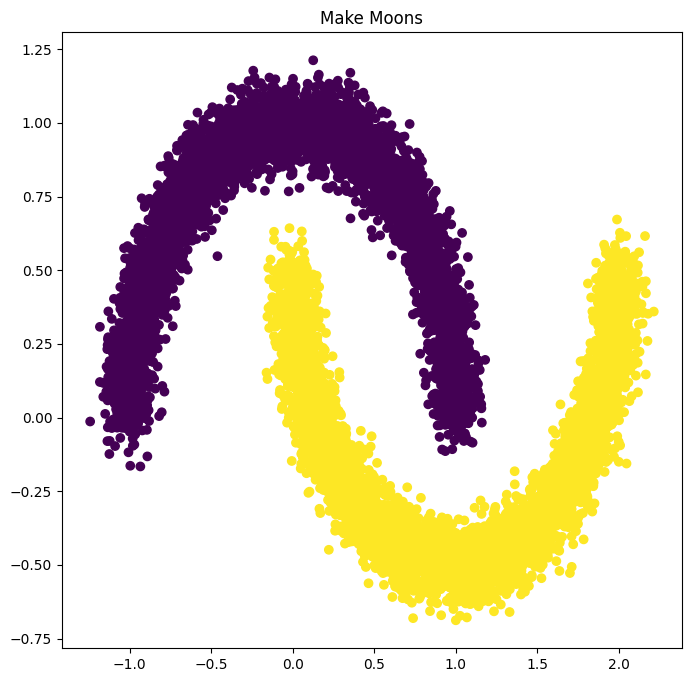

[1 0 0 ... 1 0 1]


In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
plt.title("Make Moons")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()
print(y)

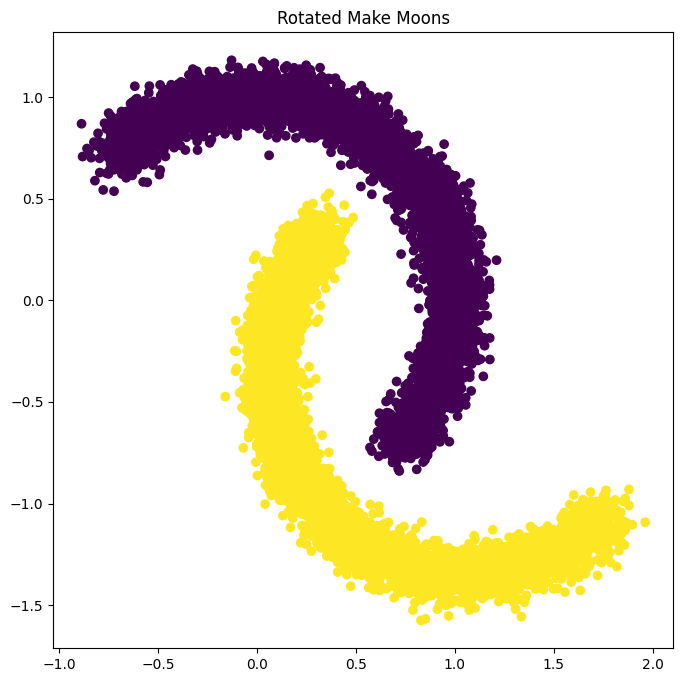

In [13]:
# Rotated Make Moons
theta = np.pi / 4
rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
rotated_X = X @ rotation_matrix
plt.figure(figsize=(8, 8))
plt.title("Rotated Make Moons")
plt.scatter(rotated_X[:, 0], rotated_X[:, 1], c=y, cmap="viridis")
plt.show()

In [14]:
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.int64)

from torch.utils.data import TensorDataset, DataLoader
dataset = TensorDataset(X, y)
rotated_dataset = TensorDataset(torch.tensor(rotated_X, dtype=torch.float32), y)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)
train_loader_rotated = DataLoader(rotated_dataset, batch_size=32, shuffle=True)

In [15]:
from hypnettorch.mnets import MLP

num_shape = X.shape[1]

# Create a fully-connected network with and without internal parameters.
mlp = MLP(n_in=num_shape, n_out=1, hidden_layers=[7, 5],
               no_weights=True)

Creating an MLP with 67 weights.


In [16]:
from hypnettorch.hnets import HMLP

hnet = HMLP(mlp.param_shapes, uncond_in_size=0, cond_in_size=4,
            layers=[50, 50], num_cond_embs=2)

print()
print('The randomly initialized input embeddings are:\n', 
      hnet.conditional_params)

# To produce main network weights for condition `0`, we can either pass
# the corresponding condition ID, or the corresponding (internally maintained)
# embedding to the `forward` of the hypernetwork.
# W0 = hnet.forward(cond_id=0)
# W0_tmp = hnet.forward(cond_input=hnet.conditional_params[0].view(1, -1))
# assert np.all([torch.equal(W0[i], W0_tmp[i]) for i in range(len(W0))])

# # Hypernetworks also allow batch processing.
# W_batch = hnet.forward(cond_id=[0, 0])
# assert np.all([torch.equal(W_batch[0][i], W_batch[1][i]) \
#                for i in range(len(W0))])

Created MLP Hypernet.
Hypernetwork with 6225 weights and 67 outputs (compression ratio: 92.91).
The network consists of 6217 unconditional weights (6217 internally maintained) and 8 conditional weights (8 internally maintained).

The randomly initialized input embeddings are:
 [Parameter containing:
tensor([-0.0067, -0.6024,  1.7970,  0.2580], requires_grad=True), Parameter containing:
tensor([ 0.0095, -0.2595,  0.0953, -1.4689], requires_grad=True)]


In [17]:
hnet.apply_hyperfan_init(mnet=mlp)

In [18]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
def calc_accuracy(X: torch.tensor, y: torch.tensor, mnet, mnet_weights):
    """Compute the test accuracy for a given dataset"""
    with torch.no_grad():
        # Process complete test set as one batch.
        logits = mnet(X, weights=mnet_weights)
        pred_lbls = torch.sigmoid(logits)
        y = y.reshape(-1,1).float()
        # print(pred_lbls )
        # print(y)
        pred_lbls = torch.round(pred_lbls)
        acc = torch.sum(y == pred_lbls) / y.numel() * 100.

    return acc

# Configure training.
lr=0.01
batchsize=32
nepochs=10

# Adam usually works well in combination with hypernetwork training.
optimizer = torch.optim.Adam(hnet.internal_params, lr=lr)
criterion = nn.BCEWithLogitsLoss()

for epoch in range(nepochs): # For each epoch.
    i = 0
    for batch_X, batch_y in train_loader:
        i += 1 
        optimizer.zero_grad()
        
        W = hnet(cond_id=0)
        f = mlp.forward(batch_X, weights=W)
         
        batch_y = batch_y.reshape(-1,1).float()
        loss = criterion(f, batch_y)
        # print(f) 
        # print(batch_y)

        W_rotated = hnet(cond_id=1)
        f_rotated = mlp.forward(batch_X, weights=W_rotated)
        loss_rotated = criterion(f_rotated, batch_y)

        loss = loss + loss_rotated
        loss.backward()
        optimizer.step()

        if i % 10 == 0:            
            print('Epoch %d, batch %d: Loss: %.3f, acc: %.2f%%' % \
                  (epoch + 1, i + 1, loss.item(), 
                   calc_accuracy(X, y, mlp, W)))
        if (i+1) % 100 == 0:
            break


# print('Training finished with test-accs: MNIST acc: %.2f%%, FashionMNIST %.2f%%' % \
#       (calc_accuracy(mnist, mnet, W_mnist),
#        calc_accuracy(fmnist, mnet, W_fmnist)))

Epoch 1, batch 11: Loss: 1.126, acc: 84.59%
Epoch 1, batch 21: Loss: 0.700, acc: 89.08%
Epoch 1, batch 31: Loss: 0.928, acc: 88.12%
Epoch 1, batch 41: Loss: 0.713, acc: 87.17%
Epoch 1, batch 51: Loss: 0.557, acc: 90.01%
Epoch 1, batch 61: Loss: 0.246, acc: 91.22%
Epoch 1, batch 71: Loss: 0.278, acc: 91.79%
Epoch 1, batch 81: Loss: 0.489, acc: 92.74%
Epoch 1, batch 91: Loss: 0.330, acc: 94.32%
Epoch 2, batch 11: Loss: 0.018, acc: 99.75%
Epoch 2, batch 21: Loss: 0.020, acc: 96.71%
Epoch 2, batch 31: Loss: 0.531, acc: 98.87%
Epoch 2, batch 41: Loss: 0.544, acc: 93.68%
Epoch 2, batch 51: Loss: 0.001, acc: 99.88%
Epoch 2, batch 61: Loss: 0.568, acc: 94.71%
Epoch 2, batch 71: Loss: 0.767, acc: 91.85%
Epoch 2, batch 81: Loss: 0.130, acc: 97.93%
Epoch 2, batch 91: Loss: 0.056, acc: 99.77%
Epoch 3, batch 11: Loss: 0.003, acc: 99.91%
Epoch 3, batch 21: Loss: 0.002, acc: 99.95%
Epoch 3, batch 31: Loss: 0.002, acc: 99.96%
Epoch 3, batch 41: Loss: 0.001, acc: 99.96%
Epoch 3, batch 51: Loss: 0.001, 

In [20]:

# Compute predictions for test batches above.
with torch.no_grad():
    X = torch.tensor(X, dtype=torch.float32)
    rotated_X = torch.tensor(rotated_X, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.int64)
    W = hnet(cond_id=0)
    preds = mlp.forward(X, weights=W)

    W_rotated = hnet(cond_id=1)
    rotated_preds = mlp.forward(rotated_X, weights=W_rotated)
    
    # Note, the network outputs are logits, and thus not normalized.
    preds = torch.sigmoid(preds)
    rotated_preds = torch.sigmoid(rotated_preds)

#     print accuracy
print("Unrotated accuracy: ", calc_accuracy(X, y, mlp, W))
print("Rotated accuracy: ", calc_accuracy(rotated_X, y, mlp, W_rotated))
    
#     mnist_preds = mnist_preds.detach().cpu().numpy()
#     fmnist_preds = fmnist_preds.detach().cpu().numpy()

Unrotated accuracy:  tensor(99.4100)
Rotated accuracy:  tensor(88.7200)


C:\Users\Hp\AppData\Local\Temp\ipykernel_26112\1178060788.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float32)
C:\Users\Hp\AppData\Local\Temp\ipykernel_26112\1178060788.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.int64)
